In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.feature import greycomatrix, greycoprops

In [2]:
def image_visualiser(img):
  rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  hsv = cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)
  fig1 = plt.figure(figsize=(16, 10))

  fig1.add_subplot(1,3,1)
  plt.imshow(rgb)
  plt.title("RGB")
  plt.axis(False)

  fig1.add_subplot(1,3,2)
  plt.imshow(gray,cmap = 'gray')
  plt.title("Gray")
  plt.axis(False)

  fig1.add_subplot(1,3,3)
  plt.imshow(hsv)
  plt.title("HSV")
  plt.axis(False)
  return(rgb,gray,hsv)

In [3]:
def mask_generator(hsv):
  lower_hsv = (1,0,0)
  upper_hsv =  (180,72,255)
  mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
  return(mask)


In [4]:
def image_segmentation_visualiser(rgb,bg_col,ROI):

    if(bg_col==1):
      image = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
      thresh = threshold_otsu(image)
      bw = closing(image < thresh, square(3))
    else:
      image = mask_generator(cv2.cvtColor(img,cv2.COLOR_RGB2HSV))
      bw = closing(image <170, square(3))
    
    cleared = clear_border(bw)

    label_image = label(cleared)
    image_label_overlay = label2rgb(label_image, image=rgb, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        if region.area >= ROI:
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [5]:
def dataset_generator(rgb,type,bg_col):
    gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
    data = np.array([[0,0,0,0,0,0]])

    if(bg_col==1):
      image = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
      thresh = threshold_otsu(image)
      bw = closing(image < thresh, square(3))
    else:
      image = mask_generator(cv2.cvtColor(img,cv2.COLOR_RGB2HSV))
      bw = closing(image <170, square(3))

    cleared = clear_border(bw)

    label_image = label(cleared)
    image_label_overlay = label2rgb(label_image, image=rgb, bg_label=0)

    if(type==1):
      ROI = 50000
    else:
      ROI = 10000
  
    for region in regionprops(label_image):
        if region.area >= ROI:
          min_row, min_col, max_row, max_col = region.bbox
          g = greycomatrix(gray[min_row : max_row,min_col : max_col], [1], [0],normed=True, symmetric=True)
          data = np.concatenate((data,np.array([[region.area,region.eccentricity,region.major_axis_length,region.minor_axis_length,greycoprops(g, 'energy')[0][0],type]])),axis=0)
    return(np.delete(data,0,0))

## Segmentation methodlogy for white background images

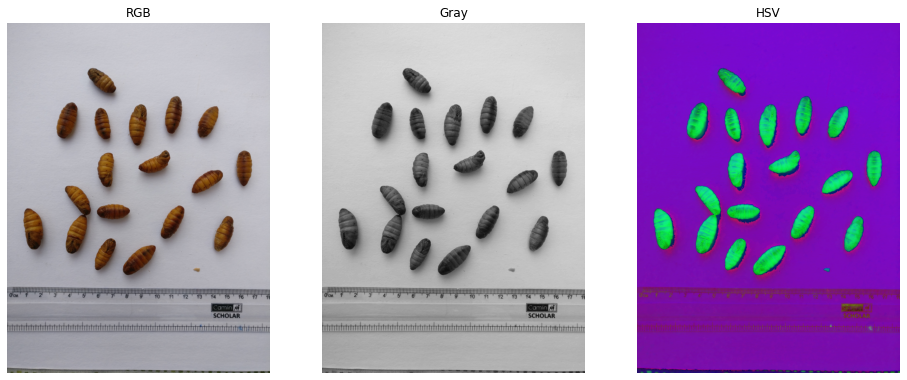

In [6]:
img = cv2.imread('PupaeDataset/Whiteb/good/1.jpg')
rgb,gray,hsv = image_visualiser(img)

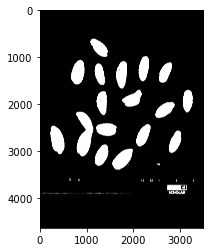

In [7]:
image = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
thresh = threshold_otsu(image)
bw = closing(gray < thresh, square(3))
cleared = clear_border(bw)
plt.imshow(cleared,cmap='gray')

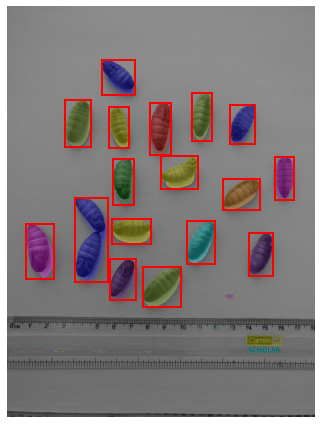

In [8]:
image_segmentation_visualiser(rgb,1,50000)

## Segmentation methodlogy for black background images

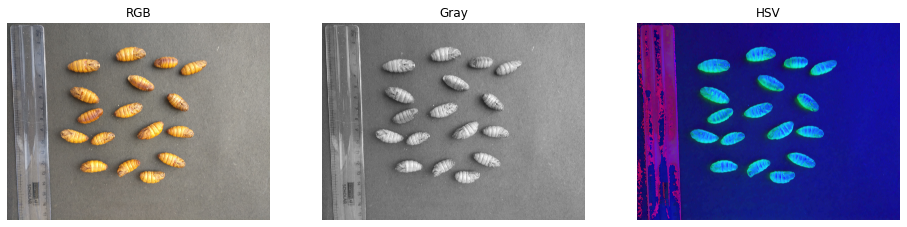

In [12]:
img = cv2.imread('PupaeDataset/Blackb/good/2.jpg')
rgb,gray,hsv = image_visualiser(img)

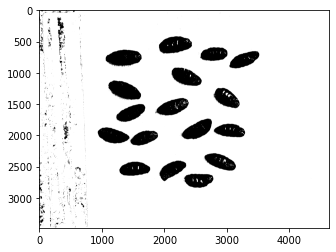

In [13]:
mask = mask_generator(hsv)
plt.imshow(mask,cmap='gray')

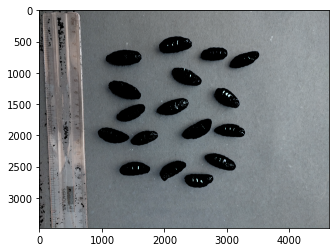

In [14]:
result = cv2.bitwise_and(img, img, mask=mask)
result = result.astype(np.uint8)
plt.imshow(result)

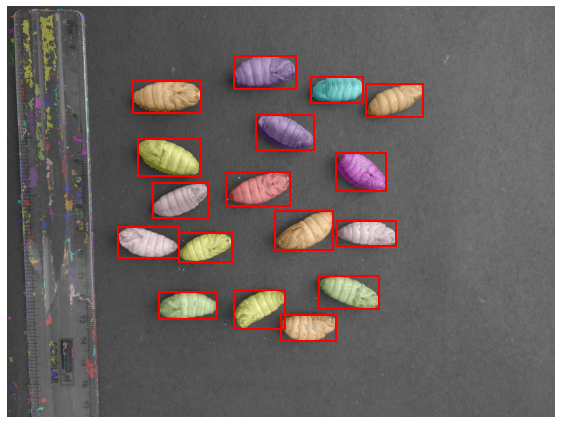

In [15]:
image_segmentation_visualiser(rgb,0,50000)

## Dataset creation

### For Black Background images

In [16]:
pic_no = [2,4,7,11]
data = np.array([[0,0,0,0,0,0]])
for i in pic_no:
  img = cv2.imread('PupaeDataset/Blackb/good/'+str(i)+'.jpg')
  data = np.concatenate((data,dataset_generator(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),1,0)), axis=0)


### For white background images

In [17]:
pic_no=[2,5]
for i in pic_no:
  img = cv2.imread('PupaeDataset/Whiteb/bad/'+str(i)+'.jpg')
  data = np.concatenate((data,dataset_generator(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),0,1)), axis=0)

In [18]:
pic_no=[3,5]
for i in pic_no:
  img = cv2.imread('PupaeDataset/Whiteb/good/'+str(i)+'.jpg')
  data = np.concatenate((data,dataset_generator(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),1,1)), axis=0)

In [19]:
df = pd.DataFrame(np.delete(data,0,0), columns = ['Area','Eccentricity','Major_axis_length','Minor_axis_length','Energy','Class'])
df.head()

,Area,Eccentricity,Major_axis_length,Minor_axis_length,Energy,Class
0,108342.0,0.873961,540.837774,262.844670,0.016651,1.0
1,75303.0,0.873894,446.645990,217.122318,0.017459,1.0
2,116491.0,0.895461,578.625784,257.569898,0.017002,1.0
3,82222.0,0.915514,513.510044,206.577736,0.020853,1.0
4,97091.0,0.876263,510.771705,246.106339,0.014228,1.0


In [20]:
df.shape

(136, 6)

In [21]:
df.to_csv('version1.csv')

## Implementing SVM

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [23]:
data = pd.read_csv('version1.csv')
data.head()

,Unnamed: 0,Area,Eccentricity,Major_axis_length,Minor_axis_length,Energy,Class
0,0,108342.0,0.873961,540.837774,262.844670,0.016651,1.0
1,1,75303.0,0.873894,446.645990,217.122318,0.017459,1.0
2,2,116491.0,0.895461,578.625784,257.569898,0.017002,1.0
3,3,82222.0,0.915514,513.510044,206.577736,0.020853,1.0
4,4,97091.0,0.876263,510.771705,246.106339,0.014228,1.0


In [24]:
data.drop(data.columns[[0]], axis = 1, inplace = True)
data.head()

,Area,Eccentricity,Major_axis_length,Minor_axis_length,Energy,Class
0,108342.0,0.873961,540.837774,262.844670,0.016651,1.0
1,75303.0,0.873894,446.645990,217.122318,0.017459,1.0
2,116491.0,0.895461,578.625784,257.569898,0.017002,1.0
3,82222.0,0.915514,513.510044,206.577736,0.020853,1.0
4,97091.0,0.876263,510.771705,246.106339,0.014228,1.0


In [25]:
x = data.iloc [:,0:4]
y = data.iloc [:,5]

In [26]:
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [28]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(108, 4)
(108,)
(28, 4)
(28,)


In [29]:
modelSVM = SVC()  
modelSVM.fit(x_train, y_train)

SVC()

In [30]:
predict_testSVM=modelSVM.predict(x_test)
predict_testSVM

array([0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

In [31]:
accuracy_test_SVM=accuracy_score(y_test,predict_testSVM)
print(accuracy_test_SVM*100)

100.0


In [32]:
array = confusion_matrix((pd.get_dummies(y_test).to_numpy()).argmax(axis=1), ((pd.get_dummies(modelSVM.predict(x_test))).to_numpy()).argmax(axis=1))

In [33]:
array

array([[ 9,  0],
       [ 0, 19]])

<AxesSubplot:>

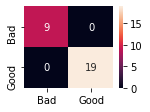

In [34]:
to_cm = pd.DataFrame(array, index = [i for i in ["Bad","Good"]],
                  columns = [i for i in ["Bad","Good"]])
plt.figure(figsize = (2,1.5))
sn.heatmap(to_cm, annot=True)

In [35]:
import seaborn as sn
import matplotlib.pyplot as plt

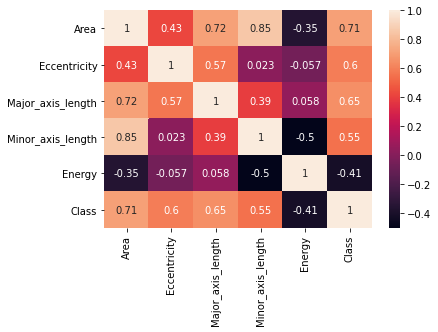

In [36]:
sn.heatmap(data.corr(), annot=True)
plt.show()
